# SI 650 / EECS 549: Homework 3 Part 2

Homework 3 Part 2 will have you working with Learning to Rank approaches, which as we've seen are highly competitive when enough data is available. Part 2 should be completed after Part 1 and will use some small parts of that code to construct an index and load data.

If you haven't worked with them before, Part 2 will expose you to [overloaded python operators](https://www.geeksforgeeks.org/operator-overloading-in-python/), which will let you call functions using alternative python syntax. For example, if you're using two Python `list` objects, you can interact with them using `+` to call the equivalent method. 

In Part 2, you'll work on the following tasks:
 - Construct and learn learning-to-rank pipelines
 - Add new features for learning-to-rank
 - Evaluate learning-to-rank models
 
Part 2 can be run on most laptops as well. Some of the machine learning models may take a few minutes to train but you are also welcome to run these on Great Lakes. None of the code in this part involves deep learning or requires a GPU.

### Launch PyTerrier
Import the packages you need and launch PyTerrier like we did in Part 1. You will still need to make sure `JAVA_HOME` is set for this part.

In [1]:
import pyterrier as pt
import pandas as pd
import os

In [2]:
if not pt.started():
    pt.init()

PyTerrier 0.7.1 has loaded Terrier 5.6 (built by craigmacdonald on 2021-09-17 13:27)


# Indexing CORD19

Like in Part 1, we'll again use the CORD19 data. However, **in Part 2, we will add in positional indexing.** This code will still look very similar to your code from Part 1. When creating the index, add the `blocks=True` argument, which will include word order information in the index. On most laptops, this process will take ~1 minute.

You may see an error `java.io.IOException: Key 8lqzfj2e is not unique: 37597,11755` during indexing but you can safely ignore the error for the purposes of this notebook.

In [3]:
cord19 = pt.datasets.get_dataset('irds:cord19/trec-covid')
pt_index_path = './terrier_trec_covid_positional_indices'

if not os.path.exists(pt_index_path + "/data.properties"):
    # create the index, using the IterDictIndexer indexer 
    iter_indexer = pt.IterDictIndexer(pt_index_path, overwrite=True, blocks=True)

    # we give the dataset get_corpus_iter() directly to the indexer
    # while specifying the fields to index and the metadata to record
    index_ref = iter_indexer.index(cord19.get_corpus_iter(), fields=('abstract',), meta=['docno', 'text'], meta_lengths=[20, 4096])

else:
    # if you already have the index, create an IndexRef from the data in pt_index_path
    # that we can use to load using the IndexFactory
    index_ref = pt.IndexRef.of(pt_index_path)

index = pt.IndexFactory.of(index_ref)

## Transformers and Operators

PyTerrier works extensively with objects/functions that _transform_ one input to another. We saw this behavior with the `BatchRetrieve` object that we used earlier to get search results, which had a `transform()` method that takes as input a dataframe, and returns another dataframe. We can think of this function as a *transformation* of the earlier dataframe (e.g., transforming the queries into results). PyTerrier has many such functions that act as  [transformers](https://pyterrier.readthedocs.io/en/latest/transformer.html). 

Let's use the transformer, `BatchRetrieve`, and this time specify that we'll use the TF-IDF word model.

In [5]:
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF")

In PyTerrier, all transformers have been coded so that they be combined using Python operators, which is an example  of operator overloading. If we want to have the output of one transformer used as the input of another transformer, we can use the `>>` operator. This operator lets us compose a series of transformations to output our document rankings.

In [6]:
# This is our first retrieval transformer, which transforms a queries dataframe to a results dataframe
tf = pt.BatchRetrieve(index, wmodel="Tf")

tf(cord19.get_topics(variant='title').head(1))

[INFO] [starting] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml
[INFO] [finished] https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml: [00:00] [18.7kB] [19.5MB/s]


,qid,docid,docno,rank,score,query
0,1,146967,jkrj0lbm,0,25.0,coronavirus origin
1,1,25564,jlzncyax,1,18.0,coronavirus origin
2,1,45549,8l411r1w,2,15.0,coronavirus origin
3,1,29359,gnxbfcod,3,14.0,coronavirus origin
4,1,63537,cpc6v40g,4,14.0,coronavirus origin
...,...,...,...,...,...,...
995,1,58583,wfcyaumm,995,4.0,coronavirus origin
996,1,59153,86vu0kjm,996,4.0,coronavirus origin
997,1,59343,9n733bet,997,4.0,coronavirus origin
998,1,59478,mx58ai55,998,4.0,coronavirus origin


Let's define our first pipeline using the `>>` operator. If we have two transformers, `a` and `b`, the result of `a >> b` is itself a transformer!

In [7]:
pipeline = tf >> tfidf

We can use this pipeline like any other transformer. Here, we'll  pass in the very first query using `head(1)` and get the results

In [8]:
pipeline(cord19.get_topics(variant='title').head(1))

[INFO] Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
[INFO] NumExpr defaulting to 8 threads.


,qid,docid,docno,rank,score,query
0,1,175892,zy8qjaai,0,7.080599,coronavirus origin
1,1,82224,8ccl9aui,1,6.775667,coronavirus origin
2,1,135326,ne5r4d4b,2,6.683114,coronavirus origin
3,1,93245,hmvo5b0q,3,6.507303,coronavirus origin
4,1,84953,ax6v6ham,4,6.483723,coronavirus origin
...,...,...,...,...,...,...
995,1,136214,ygnxmcl1,995,1.640752,coronavirus origin
996,1,91270,853ipgea,996,1.634118,coronavirus origin
997,1,146556,oshov14d,997,1.634118,coronavirus origin
998,1,32462,xtfjw1ag,998,1.592462,coronavirus origin


There many other PyTerrier operators and please see examples in the [PyTerrier documentation on operators](https://pyterrier.readthedocs.io/en/latest/operators.html)

## Task 1: Pipeline Construction (15 points)

Create a ranker that performs the following:
 - obtains the top 10 highest scoring documents by term frequency (`wmodel="Tf"`)
 - obtains the top 10 highest scoring documents by TF.IDF (`wmodel="TF_IDF"`)
 - reranks only those documents found in BOTH of the previous retrieval settings using BM25.

How many documents are retrieved by this full pipeline for the query `"chemical"`.
> If you obtain the correct solution, the document with docno `"37771"` should have a score of $12.426309	$ for query `"chemical"`.

Hints:
 - choose carefully your [PyTerrier operators](https://pyterrier.readthedocs.io/en/latest/operators.html)
 - you should not need to perform any Pandas dataframe operations

In [5]:
tf = pt.BatchRetrieve(index, wmodel="Tf") % 10
tfidf = pt.BatchRetrieve(index, wmodel="TF_IDF") % 10
bm25 = pt.BatchRetrieve(index, wmodel="BM25")

In [10]:
pipeline = (tf & tfidf) >> bm25

In [11]:
pipeline("chemical")

/Users/dershan/opt/anaconda3/lib/python3.8/site-packages/pyterrier/transformer.py:544: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  res = self.transformer.transform(topics_and_res)
/Users/dershan/opt/anaconda3/lib/python3.8/site-packages/pyterrier/transformer.py:544: FutureWarning: .transform() should be passed a dataframe. Use .search() to execute a single query.
  res = self.transformer.transform(topics_and_res)


,qid,docid,docno,rank,score,query
0,1,37771,jn5qi1jb,0,12.426309,chemical
1,1,134305,0smev8vt,1,12.292890,chemical
2,1,142104,77c9ohxj,2,12.226076,chemical
3,1,56631,sps45fj5,3,11.642770,chemical
4,1,2524,ifebw24e,4,11.439890,chemical


## Developing more complex transformers pipelines

PyTerrier has a number of useful transformers that we can use to create complex retrieval pipelines. For composing pipelines, let's first define a bit of notation:
 - $Q$: a set of queries
 - $D$: a set of documents
 - $R$: a set of retrieved documents for a set of queries

In our setting, we'll use three transformers:
 - `pt.BatchRetrieve(index, wmodel="BM25")` - input $Q$ or $R$ (retrieval or reranking), output $R$
 - `pt.rewrite.SDM()` (sequential dependence proximity model) - input $Q$, output $Q$. 
 - `pt.rewrite.Bo1QueryExpansion(index)` - input $R$, output $Q$.

Note that now, we're using BM25 instead of TF-IDF to retrieve documents.

Transformers like `SDM` are performing query augmentation. Here, `SDM` is reweighting terms using a Dirichlet language model like we talked about in class. However, many query rewrites a possible! For example, we could use WordNet to expand the query with synonyms or even define our own. 

In [4]:
bm25 = pt.BatchRetrieve(index, wmodel="BM25")
sdm = pt.rewrite.SDM()
qe = pt.rewrite.Bo1QueryExpansion(index)

Let's see how `sdm` applies to a given query. This generates a query in an [Indri-like query language](https://www.lemurproject.org/lemur/IndriQueryLanguage.php) that Terrier (cf. `pt.BatchRetrieve()`) can understand.
 - `#combine()` - is used for weighting sub-expressions
 - `#1() - matches as a phrase, i.e. how many times do the constituent words exactly match as a phrase
 - `#uw8()` and `#uw12()` look for how many times the constituent words appear in unordered windows of 8 or 12 tokens.
 - finally, the weighting model is overridden for these query terms.
  

In [13]:
sdm.search("chemical reactions").iloc[0]["query"]

'chemical reactions #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#1(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw8(chemical reactions)) #combine:0=0.1:wmodel=org.terrier.matching.models.dependence.pBiL(#uw12(chemical reactions))'

## Task 2.1: Creating Experiments to test Pipelines (3 points)

Which kinds of rankers will perform better? We can answer this by creating an [Experiment](https://pyterrier.readthedocs.io/en/latest/experiments.html) that will compare sequential dependence model and Bo1 query expansion on TREC CORD19 with the BM25 baseline. We used Experiments in Part 1, so we'll expand this idea again here to test out different pipelines.

**Your Task:** You will need to construct appropriate pipelines to compare each approach by considering the input and output datatypes of the `bm25`, `sdm` and `qe`. 

In [5]:
topics = cord19.get_topics(variant='title')
qrels = cord19.get_qrels()

In [12]:
sdm_pipe = sdm >> bm25
qe_pipe = bm25 >> qe >> bm25

In [13]:
pt.Experiment(
    [bm25, sdm_pipe, qe_pipe],
    topics,
    qrels,
    eval_metrics=["map", "ndcg", "ndcg_cut_5", "ndcg_cut_10"])

,name,map,ndcg,ndcg_cut_5,ndcg_cut_10
0,BR(BM25),0.181478,0.373328,0.611724,0.583665
1,Compose(<pyterrier.rewrite.SDM object at 0x2ab...,0.181982,0.373439,0.613116,0.586512
2,"Compose(Compose(BR(BM25), <pyterrier.rewrite.B...",0.190398,0.388397,0.619323,0.580906


### Task 2.2:  Reflection (2 points)

Which approaches result in significant increases in NDCG and MAP? Is NDCG@10 also improved? Write 2-3 sentences why you think this is the case.

B01 query expansion paired with BM25 had the best performance in terms of NDCG and MAP. However, its NDCG@10 score is the lowest among the three. This could be because there are a couple less relevant documents positioned in the front, but overall query expansion still provided a pretty decent ranking.

# Learning to Rank

Now that we have some idea how to build pipelines in PyTerrier, we'll continue our exploration by constructing and evaluating Learning to Rank pipelines.

Learning to rank is fundamentally a machine learning approach to IR. To work, we'll need to create _training data_ to learn our ranking model. We'll also want development ("dev") data to evaluate hyperparameters and test data to see how well it works. Our dataset doesn't by itself already have the data split into train, dev, and test, so we'll first need to do that.

TREC Covid only has 50 topics, which isn't a lot for training in general. However, for a homework, 50 is sufficient to show you how it works. In this case, we'll split this 30 for training (60%), 5 for validation (10%), and 15 for evaluation (30%). In your projects, you'll want to test for statistical significance (i.e., is the improvement better than what could be expected by chance?) so we will also examine statistical significance, though we have limited data (15 topics) to do this with.

When training our model, we will only re-rank the top 500 documents for each query, which is hopefully sufficient data for learning to rank. We don't set the model to rerank _all_ documents (though you can try this!) since it causes us to have to train the Learning to Rank model on all data and is often very slow in practice.

In [6]:
RANK_CUTOFF = 10
SEED=42

from sklearn.model_selection import train_test_split

tr_va_topics, test_topics = train_test_split(topics, test_size=15, random_state=SEED)
train_topics, valid_topics =  train_test_split(tr_va_topics, test_size=5, random_state=SEED)

## Defining a Feature Set for Learning to Rank

Learning to Rank requires that we define which features to use in determining a ranking. We can use scores like BM25 but it's common to try adding more complex features that take advantage of what you, the IR practitioner, knows about the data or features that would be useful.

For this part, we'll start with 7 features. PyTerrier provides [extensive support](https://pyterrier.readthedocs.io/en/latest/ltr.html#) for how to define features and calculate them for Learning to Rank. We recommend reading that documentation as you start to go over the code below. Note that several of these features will use more than just the text to compute relevance!

1.   the BM25 abstract score;
2.   sequential dependence model, scored by BM25;
3.   does the abstract contain 'coronavirus covid', scored by BM25;
4.   the BM25 score on the title (even though we didn't index it earlier!);
5.   was the paper released/published in 2020? Recent papers were more useful for this task;
6.   does the paper have a DOI, i.e. is it a formal publication?
7.   the coordinate match score for the query--i.e. how many query terms appear in the abstract.

Several of these feature require additional metadata `["title", "date", "doi"]`, which is present in the TREC covid dataset. Fortunately, we can obtain this metadata after indexing using `pt.text.get_text(cord19, ["title", "date", "doi"])` to retrieve these extra metadata columns from the original data.

There is a lot going on in this code block, but it's useful to think of this as _another_ example of operator overloading in PyTerrier. Here, we're combining features using the `**` operator, which is the [feature union](https://pyterrier.readthedocs.io/en/latest/ltr.html#calculating-features) operator in PyTerrier. 

The output of our feature union is the `ltr_feats1` object which is itself a transformer we can use to start ranking.

In [7]:
ltr_feats1 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25')) 
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int(row["doi"] is not None and len(row["doi"]) > 0)))
    ** # abstract coordinate match
    pt.BatchRetrieve(index, wmodel="CoordinateMatch")
)

# for reference, lets record the feature names here too
fnames=["BM25", "SDM", 'coronavirus covid', 'title', "2020", "hasDoi", "CoordinateMatch"]

To get a sense of what this process is doing, let's look at the output for the query "coronavirus origin". We can see that we now have extra document metadata columns `["title", "date", "doi"]`, as well as the `"features"` column, which is what we'll use for learning. 

In [41]:
ltr_feats1.search("coronavirus origin")

15:04:24.568 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,qid,docid,docno,rank,score,query,title,date,doi,features
0,1,175892,zy8qjaai,0,11.915479,coronavirus origin,The battle against SARS and MERS coronaviruses...,2018-07-28,10.1002/ame2.12017,"[11.915479443193252, 12.058058237271272, 4.066..."
1,1,82224,8ccl9aui,1,11.550953,coronavirus origin,Mosaic evolution of the severe acute respirato...,2004,,"[11.55095262556724, 11.69464350657987, 3.18074..."
2,1,135326,ne5r4d4b,2,11.268729,coronavirus origin,Origin and evolution of pathogenic coronaviruses,2018-12-10,10.1038/s41579-018-0118-9,"[11.26872908286073, 11.26872908286073, 3.73231..."
3,1,122804,75773gwg,3,11.165944,coronavirus origin,Zoonotic origins of human coronavirus 2019 (HC...,2020,,"[11.165943985807157, 11.165943985807157, 5.567..."
4,1,122805,kn2z7lho,4,11.165944,coronavirus origin,Zoonotic origins of human coronavirus 2019 (HC...,2020,,"[11.165943985807157, 11.165943985807157, 5.567..."
5,1,122806,4fb291hq,5,11.165944,coronavirus origin,Zoonotic origins of human coronavirus 2019 (HC...,2020,,"[11.165943985807157, 11.165943985807157, 5.567..."
6,1,187888,hl967ekh,6,11.165944,coronavirus origin,Zoonotic origins of human coronavirus 2019 (HC...,2020-05-16,10.24272/j.issn.2095-8137.2020.031,"[11.165943985807157, 11.165943985807157, 5.567..."
7,1,109967,kgifmjvb,7,10.982382,coronavirus origin,Tracking the origin of early COVID-19 cases in...,2020,,"[10.98238225417628, 11.125659067727756, 5.6850..."
8,1,93245,hmvo5b0q,8,10.968774,coronavirus origin,Understanding Coronavirus,2020,,"[10.968774450337538, 11.111910932288065, 5.618..."
9,1,135870,wmfcey6f,9,10.955257,coronavirus origin,Tracking the origin of early COVID-19 cases in...,2020-05-17,10.1016/j.ijid.2020.05.046,"[10.955256957587741, 11.098547246854947, 5.669..."


We can also look at the raw feature values themselves too. Here, we'll look at the features for the first document. Note that the BM25 in the "score" column above is also the first value in the feature array (20.54), because we used an identity transformer, which returns the same value as its input.

In [9]:
ltr_feats1.search("coronovirus origin").iloc[0]["features"]

12:38:32.123 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


array([20.54147667, 20.54147667,  2.89976767,  0.        ,  1.        ,
        1.        ,  1.        ])

## Actually Doing the Learning for Learning to Rank

In class, we talked about three types of Learning to rank: pointwise, pairwise, and listwise. Here, we'll train a few models for two of these types, listwise and pointwise. 

 - coordinate ascent from FastRank, a listwise linear technique
 - random forests from `scikit-learn`, a pointwise regression tree technique
 - LambdaMART from LightGBM, a listwise regression tree technique

We can use the same feature pipeline, `ltr_feats1`, with all three.  To train the ranker, we compose it (`>>`) with the learned model. We use `pt.ltr.apply_learned_model()` which knows how to deal with different learners.

The full pipeline is then fitted (learned) using `.fit()`, specifying the training topics and qrels, much like how we train models with Scikit-Learn. Importantly, the preceding stages of the pipeline (retrieval and feature calculation) are applied to the training topics in order to obtain the results, which are then passed to the learning to rank technique. LightGBM has early stopping enabled, which uses a validation topics set--similarly the validation topics are transformed into validation results.

Finally, `%time` is notebook "magic command" specific to Juypyter which displays how long learning takes for each technique. Learning for each technique takes under 30 seconds.

In [8]:
import fastrank

train_request = fastrank.TrainRequest.coordinate_ascent()

params = train_request.params
params.init_random = True
params.normalize = True
params.seed = 1234567

ca_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(train_request, form='fastrank')

%time ca_pipe.fit(train_topics, cord19.get_qrels())

01:45:31.614 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 58.8 s, sys: 595 ms, total: 59.4 s
Wall time: 29.6 s


Now, let's try learning a different pointwise model to estimate relevance scores using a Random Forest model from Scikit-Learn. This is a good example of how we can use off-the-shelf regression models in PyTerrier to perform learning to rank.

In [9]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)

rf_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(rf)

%time rf_pipe.fit(train_topics, cord19.get_qrels())

01:45:55.351 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.8s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    2.3s


CPU times: user 13.1 s, sys: 672 ms, total: 13.8 s
Wall time: 9.98 s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    4.1s finished


Finally, let's use a list-wise approach, which typically performs best among the three types of Learning to Rank

In [10]:
import lightgbm as lgb

# this configures LightGBM as LambdaMART
lmart_l = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe = ltr_feats1 >> pt.ltr.apply_learned_model(lmart_l, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

01:46:06.931 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


01:46:09.592 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 351
[LightGBM] [Info] Number of data points in the train set: 65832, number of used features: 7
[Li

/home/techen/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/techen/.local/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


## Evaluating all the solutions 

We've fit the three Learning to Rank models so we can now use them to predict relevance scores for the held-out 15 topics (queries) in our test set. Note that if we wanted to do any tuning (e.g., pick the number of leaves in our `RandomForestRegressor`, we could run this evaluation on our held-out _dev_ set and pick the hyperparameters that produced best performance on it).

### Task 3: Create an experiment to compare (5 points)

Create a new `Experiment` to compare our three solutions and BM25 at the `RANK_CUTOFF` (four models in total). Report MAP, NDCG, and NDCG@10 measures and one new measure: mean response time (`"mrt"`), which will tell us how fast the models are able to score documents--something important if we're going to use them in the real world!

In [23]:
pt.Experiment(
    [ca_pipe, rf_pipe, lmart_x_pipe, (bm25 % RANK_CUTOFF)],
    test_topics,
    qrels, 
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"])

13:58:06.180 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
13:58:07.777 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.0s finished


13:58:09.499 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt
0,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.012253,0.049092,0.580835,217.216858
1,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.011271,0.045830,0.551404,112.977960
2,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.009926,0.042458,0.528034,104.096169
3,"RankCutoff(BR(BM25), 10)",0.010480,0.043844,0.537236,48.512402


Thats really interesting – all three learned models could improve NDCG@10 over BM25, but the coordinate ascent model improved the most (significantly so on all three metrics, but again on only 15 queries). Coordinate Ascent improved upto 10 queries.

## Analysis: What Features Matter?

Since we're _learning_ a ranking model, we can inspect that model to see what information it's using. One option for inspecting the model is to evaluate the performance of each feature independently to see how much it contributes to the eventual relevance. To examine each feature, we will create separate a separate model from each feature in our feature pipeline (`ltr_feats1`) by using `pt.ltr.feature_to_score(i)` with a particular feature number $i$. In essence, this will only score the relevance using a single feature's values, even though we've already calculated all of them.

In [14]:
pt.Experiment(
    [ltr_feats1 >> pt.ltr.feature_to_score(i) for i in range(len(fnames))],
    test_topics,
    qrels, 
    names=fnames,
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "num_rel_ret"])

09:00:18.787 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
09:00:20.426 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
09:00:22.065 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
09:00:23.714 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Def

,name,map,ndcg,ndcg_cut_10,num_rel_ret
0,BM25,0.010480,0.043844,0.537236,95.0
1,SDM,0.010429,0.043568,0.535770,95.0
2,coronavirus covid,0.011637,0.046777,0.562223,95.0
3,title,0.011799,0.047354,0.567363,95.0
4,2020,0.011064,0.045604,0.555846,95.0
5,hasDoi,0.009928,0.042970,0.531974,95.0
6,CoordinateMatch,0.010742,0.044333,0.540893,95.0


### Inspecting the models

To get a sense of feature importance, we can also analyze the learned models themselves using their internal feature weights in the Scikit-Learn models. Here, we'll plot the feature importances in a few ways. For the coordinate ascent model, we plot the feature weights (note the log-scale y-axis); while for the regression-tree based techniques, we report the feature importance.

<ipython-input-24-72f0db59652a>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


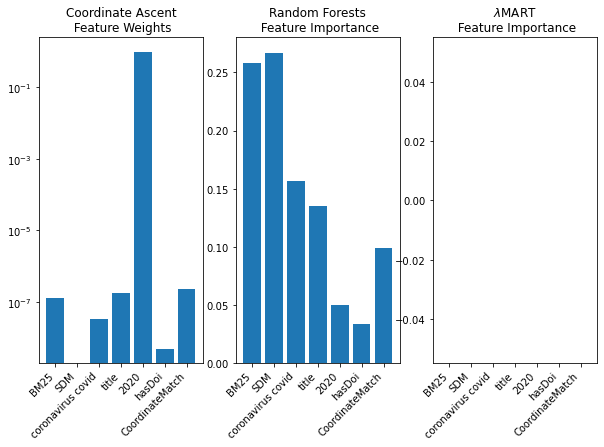

In [24]:
%matplotlib inline
import matplotlib.pyplot as plt, numpy as np

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(10, 6))

ax0.bar(np.arange(len(fnames)), ca_pipe[1].model.to_dict()['Linear']['weights'])
ax0.set_xticks(np.arange(len(fnames)))
ax0.set_xticklabels(fnames, rotation=45, ha='right')
ax0.set_title("Coordinate Ascent\n Feature Weights")
ax0.set_yscale('log')

ax1.bar(np.arange(len(fnames)), rf.feature_importances_)
ax1.set_xticks(np.arange(len(fnames)))
ax1.set_xticklabels(fnames, rotation=45, ha='right')
ax1.set_title("Random Forests\n Feature Importance")

ax2.bar(np.arange(len(fnames)), lmart_l.feature_importances_)
ax2.set_xticks(np.arange(len(fnames)))
ax2.set_xticklabels(fnames, rotation=45, ha='right')
ax2.set_title("$\lambda$MART\n Feature Importance")

fig.show()

## Task 4: Adding new features (15 points)

We've seen how to develop Learning to Rank models and analyze features. Your task is the following:

  - Define _at least_ two additional features to use in learning to rank models. These can be functions that you define or additional options from PyTerrier
  - Include your new features in a new learning to rank pipeline using the three approaches we have above to create three new models
  - Evaluate your new models against the old models in an Experiment
 
**Full credit will depend on one of your new models outperforming the best of the initial three models.**

You should aim to evaluate your features initially on the `dev` set, rather than the `test` set in order to avoid overfitting your features (i.e., never look at the test set until the end). You can use the feature and model inspection code to give you some idea of what the model is looking at. We also recommend looking at the data directly to think about what kinds of features might be useful

In [11]:
ltr_feats2 = (bm25 % RANK_CUTOFF) >> pt.text.get_text(cord19, ["title", "date", "doi"]) >> (
    pt.transformer.IdentityTransformer()
    ** # sequential dependence
    (sdm >> bm25)
    ** # score of text for query 'coronavirus covid'
    (pt.apply.query(lambda row: 'coronavirus covid') >> bm25)
    ** # score of text for query 'pandemic disease infection'
    (pt.apply.query(lambda row: 'pandemic disease infection') >> bm25)
    ** # score of text for query 'mrna vaccine'
    (pt.apply.query(lambda row: 'mrna vaccine') >> bm25)
    ** # score of title (not originally indexed)
    (pt.text.scorer(body_attr="title", takes='docs', wmodel='BM25'))
    ** # date 2020
    (pt.apply.doc_score(lambda row: int("2020" in row["date"])))
    ** # has doi
    (pt.apply.doc_score(lambda row: int( row["doi"] is not None and len(row["doi"]) > 0)))
    ** # abstract coordinate match
    (pt.BatchRetrieve(index, wmodel="CoordinateMatch"))
)

# for reference, lets record the feature names here too
fnames_new=["BM25", "SDM", 'coronavirus covid', "pandemic", 'title_bm25', 'title_dph', "2020", "hasDoi", "CoordinateMatch"]

In [14]:
train_request_new = fastrank.TrainRequest.coordinate_ascent()

params_new = train_request_new.params
params_new.init_random = True
params_new.normalize = True
params_new.seed = 1234567

ca_pipe_new = ltr_feats2 >> pt.ltr.apply_learned_model(train_request_new, form='fastrank')

%time ca_pipe_new.fit(train_topics, cord19.get_qrels())

02:07:39.332 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


CPU times: user 21min 16s, sys: 2.34 s, total: 21min 19s
Wall time: 8min 16s


In [15]:
rf_new = RandomForestRegressor(n_estimators=400, verbose=1, random_state=SEED, n_jobs=2)
rf_pipe_new = ltr_feats2 >> pt.ltr.apply_learned_model(rf_new)

%time rf_pipe_new.fit(train_topics, cord19.get_qrels())

02:15:55.638 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   41.7s


CPU times: user 3min 8s, sys: 2.4 s, total: 3min 10s
Wall time: 1min 46s


[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:  1.4min finished


In [12]:
lmart_l_new = lgb.LGBMRanker(
    task="train",
    silent=False,
    min_data_in_leaf=1,
    min_sum_hessian_in_leaf=1,
    max_bin=255,
    num_leaves=31,
    objective="lambdarank",
    metric="ndcg",
    ndcg_eval_at=[10],
    ndcg_at=[10],
    eval_at=[10],
    learning_rate= .1,
    importance_type="gain",
    num_iterations=100,
    early_stopping_rounds=5
)

lmart_x_pipe_new = ltr_feats2 >> pt.ltr.apply_learned_model(lmart_l_new, form="ltr", fit_kwargs={'eval_at':[10]})

%time lmart_x_pipe_new.fit(train_topics, cord19.get_qrels(), valid_topics, cord19.get_qrels())

02:04:39.990 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 300 received 304, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


02:04:55.317 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
/home/techen/.local/lib/python3.8/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/home/techen/.local/lib/python3.8/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] early_stopping_round is set=5, early_stopping_rounds=5 will be ignored. Current value: early_stopping_round=5
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[LightGBM] [Warning] min_data_in_leaf is set=1, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 115
[LightGBM] [Info] Number of data points in the train set: 1048872, number of used features: 9
[

In [16]:
pt.Experiment(
    [ca_pipe, ca_pipe_new, rf_pipe, rf_pipe_new, lmart_x_pipe, lmart_x_pipe_new],
    valid_topics,
    qrels, 
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"])

02:17:38.035 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


02:17:40.284 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


02:18:00.432 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.2s finished


02:18:02.673 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.7s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    3.5s finished


02:18:23.853 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b408273ebe0>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


02:18:25.756 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


/home/techen/.local/lib/python3.8/site-packages/pyterrier/transformer.py:760: UserWarning: Got number of results different expected from <pyterrier.batchretrieve.TextScorer object at 0x2b4086fe5340>, expected 50 received 54, feature scores for any missing documents be 0, extraneous documents will be removed
  warn("Got number of results different expected from %s, expected %d received %d, feature scores for any missing documents be 0, extraneous documents will be removed" % (repr(m), num_results, len(res)))


,name,map,ndcg,ndcg_cut_10,mrt
0,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017341,0.064571,0.704892,379.139772
1,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017610,0.066213,0.724416,3681.788384
2,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017559,0.064429,0.707140,411.478075
3,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017929,0.065021,0.717578,3848.800651
4,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017685,0.064586,0.712534,340.058003
5,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.017685,0.064586,0.712534,3094.988905


In [17]:
pt.Experiment(
    [ca_pipe, ca_pipe_new, rf_pipe, rf_pipe_new, lmart_x_pipe, lmart_x_pipe_new],
    test_topics,
    qrels, 
    eval_metrics=["map", "ndcg", "ndcg_cut_10", "mrt"])

02:53:20.789 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:53:23.219 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:53:25.215 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.0s finished


02:53:27.544 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 400 out of 400 | elapsed:    0.0s finished


02:53:29.667 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.
02:53:31.910 [main] WARN org.terrier.querying.ApplyTermPipeline - The index has no termpipelines configuration, and no control configuration is found. Defaulting to global termpipelines configuration of 'Stopwords,PorterStemmer'. Set a termpipelines control to remove this warning.


,name,map,ndcg,ndcg_cut_10,mrt
0,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.012273,0.049290,0.583235,275.312981
1,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.012245,0.049252,0.582693,159.541085
2,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.011271,0.045830,0.551404,135.109872
3,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.011362,0.046113,0.557297,156.735520
4,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.009926,0.042458,0.528034,129.474791
5,"Compose(Compose(Compose(RankCutoff(BR(BM25), 1...",0.009926,0.042458,0.528034,148.184370
